In [ ]:
# ! pip install facenet_pytorch

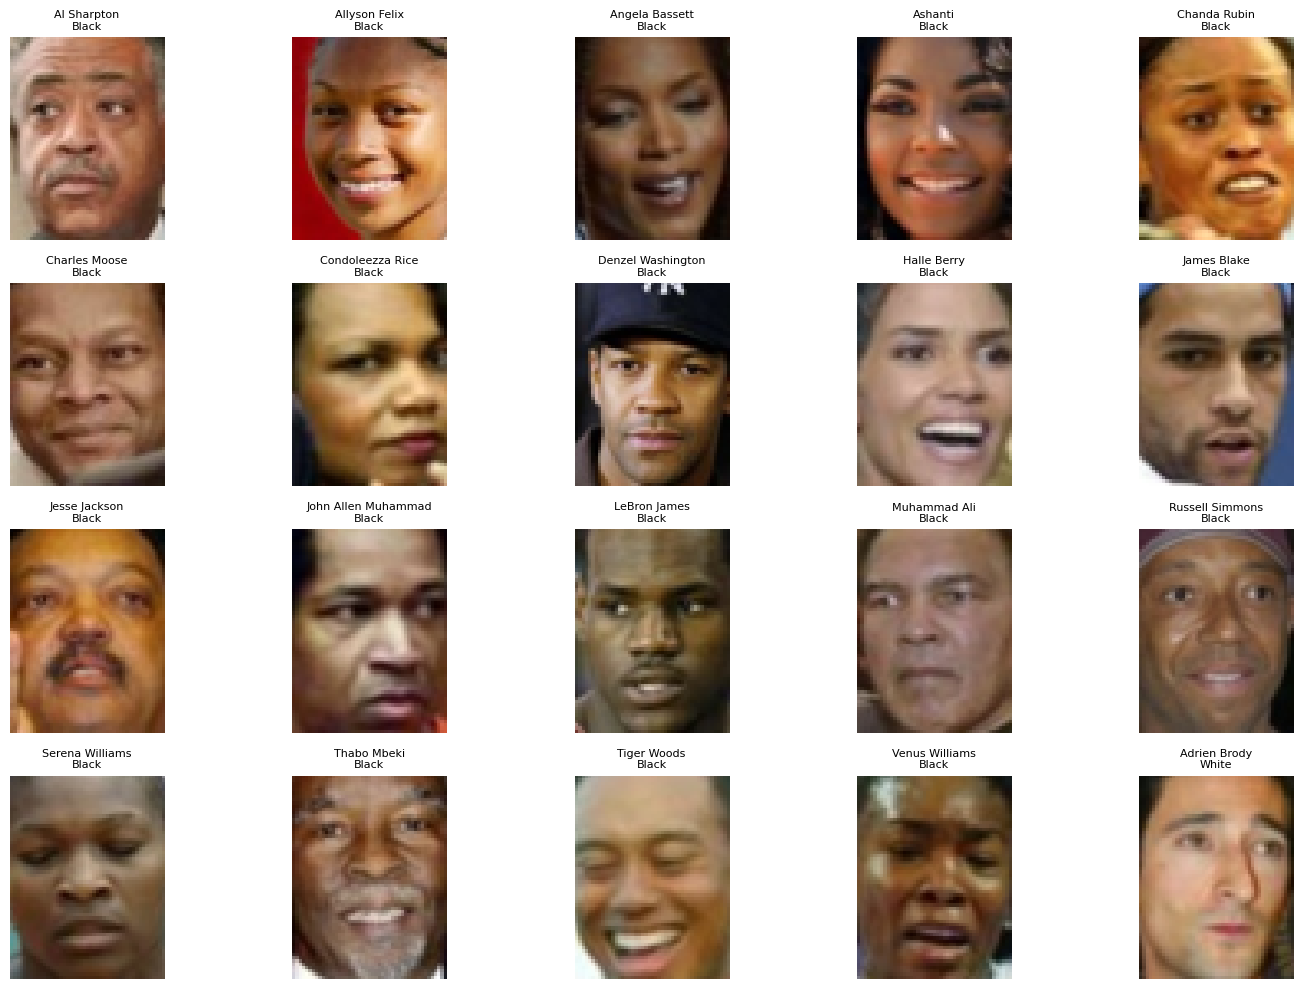

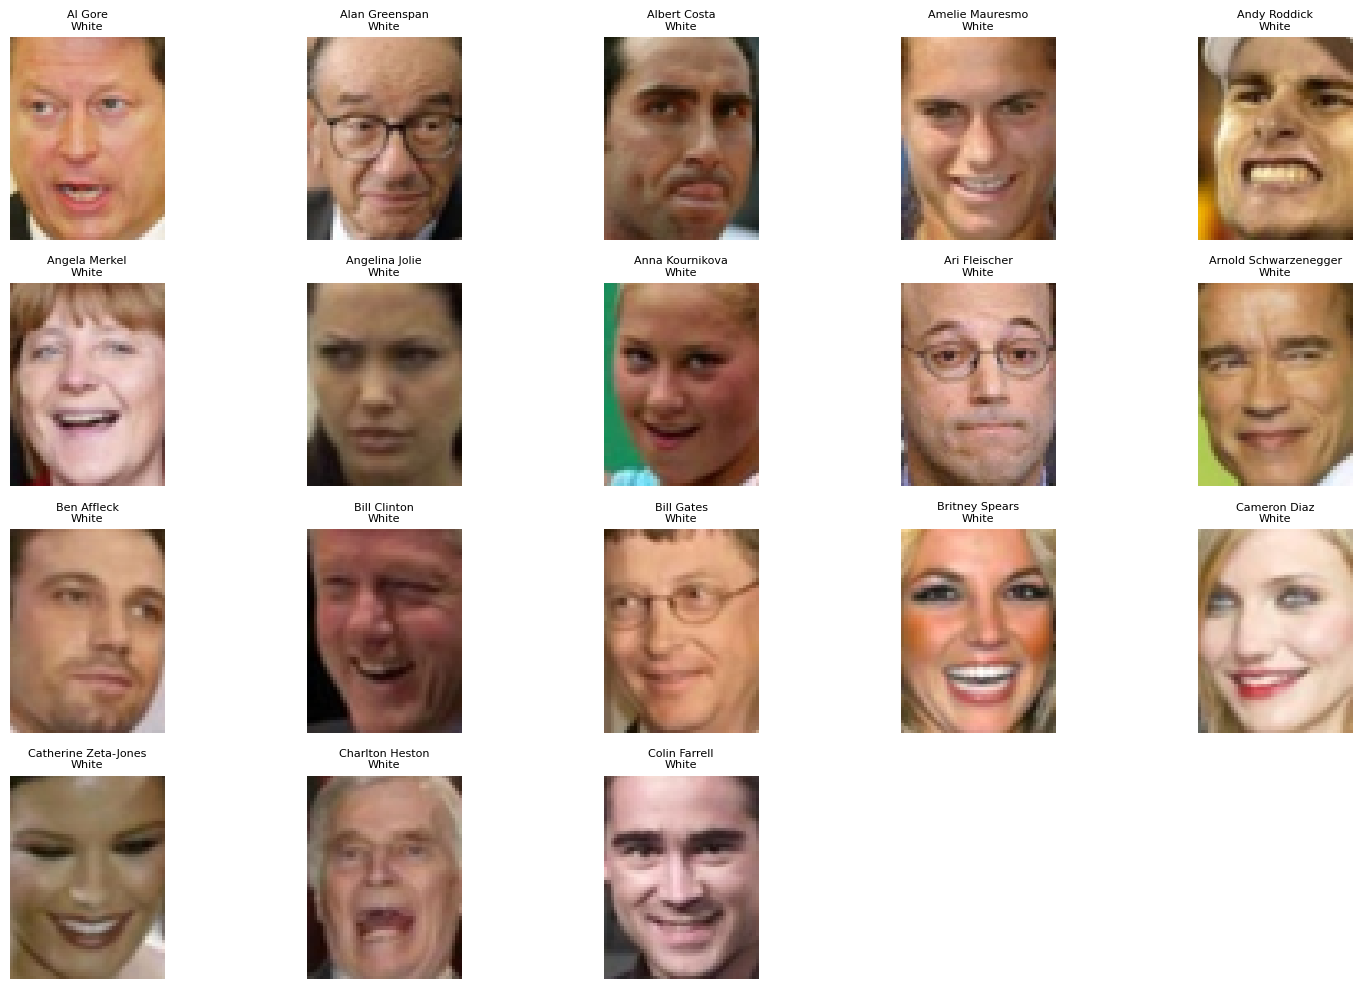

In [66]:
import torch
from facenet_pytorch import InceptionResnetV1
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from collections import defaultdict
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_lfw_people
import torchvision.transforms as transforms
import matplotlib.pyplot as plt



# Load LFW dataset (color=True to keep RGB images)
lfw = fetch_lfw_people(min_faces_per_person=5, resize=0.5, color=True)
images = lfw.images  # (n_samples, h, w, 3)
labels = lfw.target
label_names = lfw.target_names

# Your race mapping
race_mapping = {
    "Al Sharpton": "Black",
    "Allyson Felix": "Black",
    "Angela Bassett": "Black",
    "Ashanti": "Black",
    "Chanda Rubin": "Black",
    "Charles Moose": "Black",
    "Condoleezza Rice": "Black",
    "Denzel Washington": "Black",
    "Halle Berry": "Black",
    "James Blake": "Black",
    "Jesse Jackson": "Black",
    "John Allen Muhammad": "Black",
    "LeBron James": "Black",
    "Muhammad Ali": "Black",
    "Russell Simmons": "Black",
    "Serena Williams": "Black",
    "Thabo Mbeki": "Black",
    "Tiger Woods": "Black",
    "Venus Williams": "Black",
    "Adrien Brody": "White",
    "Al Gore": "White",
    "Alan Greenspan": "White",
    "Albert Costa": "White",
    "Amelie Mauresmo": "White",
    "Andy Roddick": "White",
    "Angela Merkel": "White",
    "Angelina Jolie": "White",
    "Anna Kournikova": "White",
    "Ari Fleischer": "White",
    "Arnold Schwarzenegger": "White",
    "Ben Affleck": "White",
    "Bill Clinton": "White",
    "Bill Gates": "White",
    "Britney Spears": "White",
    "Cameron Diaz": "White",
    "Catherine Zeta-Jones": "White",
    "Charlton Heston": "White",
    "Colin Farrell": "White"
}

# Create name -> indices mapping
name_to_indices = defaultdict(list)
for idx, label_idx in enumerate(labels):
    name = label_names[label_idx]
    name_to_indices[name].append(idx)

i = 0
batch_size = 20

matched_names = [name for name in race_mapping]

while i < len(matched_names):
    batch_names = matched_names[i:i + batch_size]

    plt.figure(figsize=(15, 10))
    for j, name in enumerate(batch_names):
        idx = name_to_indices[name][0]  # Show the first image
        plt.subplot(4, 5, j + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"{name}\n{race_mapping[name]}", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

    i += batch_size

In [110]:
from sklearn.model_selection import StratifiedShuffleSplit


# Filter indices for people in race_mapping only
selected_indices = []
selected_names = []
for name in race_mapping.keys():
    if name in name_to_indices:
        selected_indices.extend(name_to_indices[name])
        selected_names.append(name)

X = images[selected_indices]  # filtered images
y_names = [label_names[labels[i]] for i in selected_indices]

# Encode string labels to integers
le = LabelEncoder()
y = le.fit_transform(y_names)

# Load pretrained Facenet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Preprocess and extract embeddings
def preprocess(img):
    # facenet expects (3,160,160) float tensors normalized in [-1,1]
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((160,160)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
    ])
    return transform(img)

embeddings = []
with torch.no_grad():
    for img in X:
        img_t = preprocess(img).to(device)
        emb = model(img_t.unsqueeze(0))  # batch size 1
        embeddings.append(emb.cpu().numpy()[0])

X_embedded = np.array(embeddings)


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_idx, test_idx in sss.split(X_embedded, y):
    X_train, X_test = X_embedded[train_idx], X_embedded[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    train_selected_indices = np.array(selected_indices)[train_idx]
    test_selected_indices = np.array(selected_indices)[test_idx]



print(f'Trainset size: {X_train.shape[0]}')
print(f'Testset size: {X_test.shape[0]}')

# SVM classifier with scaling pipeline
clf = make_pipeline(StandardScaler(), SVC(kernel='linear', class_weight='balanced'))
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Trainset size: 385
Testset size: 97
Classification Report:

                       precision    recall  f1-score   support

         Adrien Brody       1.00      1.00      1.00         2
              Al Gore       1.00      1.00      1.00         2
          Al Sharpton       1.00      1.00      1.00         1
       Alan Greenspan       1.00      1.00      1.00         1
         Albert Costa       1.00      1.00      1.00         1
        Allyson Felix       1.00      1.00      1.00         1
      Amelie Mauresmo       1.00      1.00      1.00         4
         Andy Roddick       1.00      1.00      1.00         3
       Angela Bassett       1.00      1.00      1.00         1
        Angela Merkel       1.00      1.00      1.00         1
       Angelina Jolie       1.00      1.00      1.00         4
      Anna Kournikova       1.00      1.00      1.00         2
        Ari Fleischer       1.00      1.00      1.00         3
Arnold Schwarzenegger       1.00      1.00      1.00     

In [118]:
from sklearn.metrics import classification_report, accuracy_score


def evaluate_per_race(y_test, y_pred, le, test_selected_indices, labels, label_names, race_mapping):
    name_list = [label_names[labels[idx]] for idx in test_selected_indices]

    race_to_indices = {}
    for i, name in enumerate(name_list):
        race = race_mapping.get(name, "Unknown")
        race_to_indices.setdefault(race, []).append(i)

    for race, indices in race_to_indices.items():
        if not indices:
            continue
        y_true_race = y_test[indices]
        y_pred_race = y_pred[indices]

        # Filter target names to only the classes present
        present_labels = np.unique(y_true_race)
        present_class_names = le.inverse_transform(present_labels)

        print(f"\nClassification report for race: {race}")
        print(classification_report(
            y_true_race,
            y_pred_race,
            labels=present_labels,
            target_names=present_class_names,
            zero_division=0
        ))
        acc = accuracy_score(y_true_race, y_pred_race)
        print(f"Accuracy for race {race}: {acc:.4f}")



In [119]:
# evaluate_per_race(y_test, y_pred, le, race_mapping)
evaluate_per_race(y_test, y_pred, le, test_selected_indices, labels, label_names, race_mapping)



Classification report for race: White
                       precision    recall  f1-score   support

         Adrien Brody       1.00      1.00      1.00         2
              Al Gore       1.00      1.00      1.00         2
       Alan Greenspan       1.00      1.00      1.00         1
         Albert Costa       1.00      1.00      1.00         1
      Amelie Mauresmo       1.00      1.00      1.00         4
         Andy Roddick       1.00      1.00      1.00         3
        Angela Merkel       1.00      1.00      1.00         1
       Angelina Jolie       1.00      1.00      1.00         4
      Anna Kournikova       1.00      1.00      1.00         2
        Ari Fleischer       1.00      1.00      1.00         3
Arnold Schwarzenegger       1.00      1.00      1.00         9
          Ben Affleck       1.00      1.00      1.00         1
         Bill Clinton       1.00      1.00      1.00         6
           Bill Gates       1.00      1.00      1.00         3
       Britney 

In [82]:
import matplotlib.pyplot as plt

def plot_sample_res(X_test, X_embedded, selected_indices, le, y_test, y_pred, race_mapping, images):
  # Number of samples to display
  num_samples = 10
  indices = np.random.choice(len(X_test), size=num_samples, replace=False)

  plt.figure(figsize=(15, 5))
  for i, idx in enumerate(indices):
      # Get original image index for display
      embedded_idx = np.where((X_embedded == X_test[idx]).all(axis=1))[0][0]
      orig_idx = selected_indices[embedded_idx]

      true_name = le.inverse_transform([y_test[idx]])[0]
      pred_name = le.inverse_transform([y_pred[idx]])[0]
      title_color = 'green' if true_name == pred_name else 'red'
      race = race_mapping.get(true_name, "Unknown")

      plt.subplot(2, num_samples // 2, i + 1)
      plt.imshow(images[orig_idx])
      plt.axis('off')


      plt.title(f"{race}\nTrue: {true_name}\nPred: {pred_name}", color=title_color, fontsize=10)

  plt.tight_layout()
  plt.show()


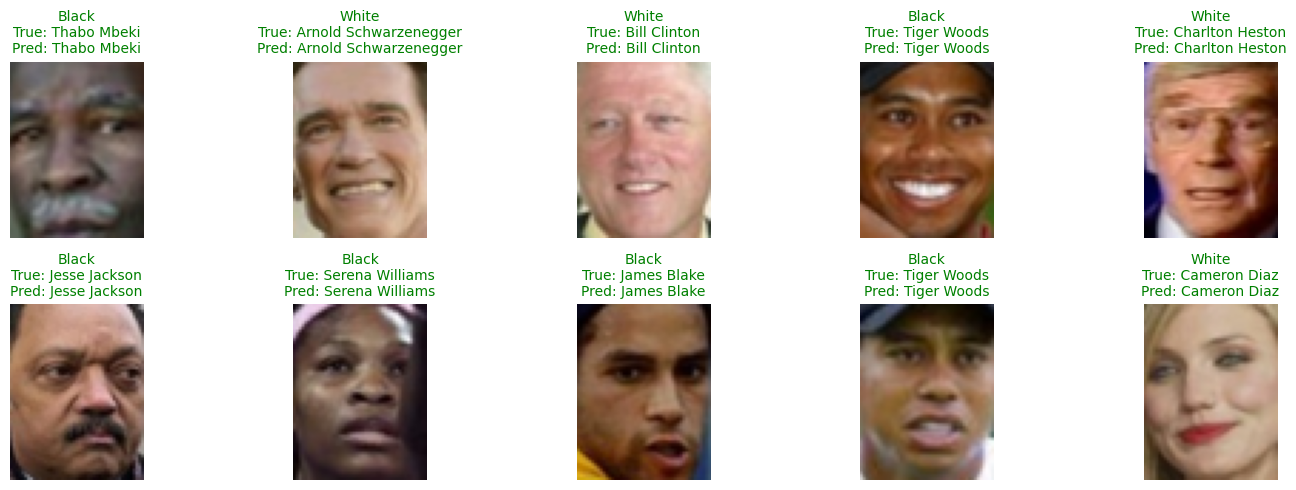

In [83]:
plot_sample_res(X_test, X_embedded, selected_indices, le, y_test, y_pred, race_mapping, images)

Adverserial

In [127]:
def train_strong_universal_perturbation(model, images, epsilon=0.05, alpha=0.1, iters=10, epochs=2):
    device = next(model.parameters()).device
    images = images.to(device)
    model.eval()

    perturbation = torch.zeros_like(images[0], device=device, requires_grad=True)
    optimizer = torch.optim.Adam([perturbation], lr=alpha)

    for epoch in range(epochs):
        total_loss = 0
        for i in range(len(images)):
            optimizer.zero_grad()
            img = images[i:i+1]
            perturbed_img = torch.clamp(img + perturbation, -1, 1)
            emb_orig = F.normalize(model(img), dim=1)
            emb_pert = F.normalize(model(perturbed_img), dim=1)
            cos_sim = (emb_orig * emb_pert).sum(dim=1)
            loss = cos_sim.mean()
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                perturbation.data = torch.clamp(perturbation.data, -epsilon, epsilon)
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs} Avg Cosine Sim: {total_loss / len(images):.4f}")
    return perturbation.detach()

white_images = []
white_train_indices = []

for i, orig_idx in enumerate(train_selected_indices):
    name = label_names[labels[orig_idx]]
    race = race_mapping.get(name, "Unknown")
    if race == "White":
        img = images[orig_idx]
        img_t = preprocess(img).squeeze(0)
        white_images.append(img_t)
        white_train_indices.append(i)

white_images = torch.stack(white_images).to(device)
universal_perturbation = train_strong_universal_perturbation(model, white_images, epsilon=0.07, alpha=0.1, iters=10, epochs=2)

# === Step 3: Apply Cloaking ===

X_train_cloaked = []
for i, orig_idx in enumerate(train_selected_indices):
    name = label_names[labels[orig_idx]]
    race = race_mapping.get(name, "Unknown")
    img = images[orig_idx]
    img_t = preprocess(img).unsqueeze(0).to(device)

    if race == "White":
        perturbed_img = torch.clamp(img_t + universal_perturbation, -1, 1)
        with torch.no_grad():
            emb = model(perturbed_img).cpu().numpy()[0]
    else:
        with torch.no_grad():
            emb = model(img_t).cpu().numpy()[0]

    X_train_cloaked.append(emb)

X_train_cloaked = np.array(X_train_cloaked)

Epoch 1/2 Avg Cosine Sim: 0.3466
Epoch 2/2 Avg Cosine Sim: 0.2135


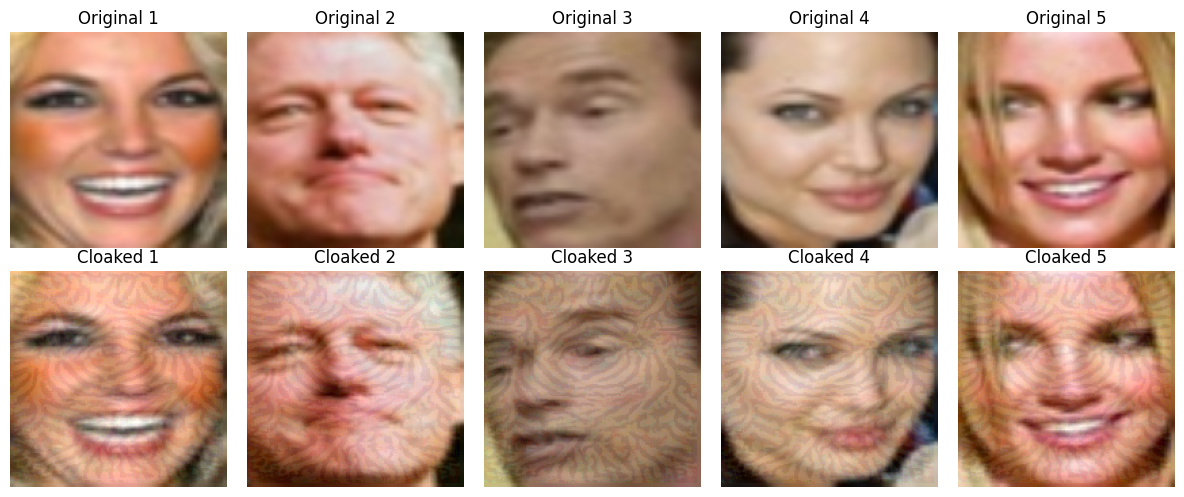

In [128]:
import matplotlib.pyplot as plt

def imshow(tensor, title=None):
    tensor = tensor.cpu().clone()
    tensor = (tensor + 1) / 2  # from [-1,1] to [0,1]
    tensor = tensor.clamp(0, 1)
    np_img = tensor.permute(1, 2, 0).numpy()
    plt.imshow(np_img)
    if title:
        plt.title(title)
    plt.axis('off')

num_to_show = 5
plt.figure(figsize=(12, 5))

for idx, i in enumerate(white_indices[:num_to_show]):
    original_img = preprocess(X[np.where((X_embedded == X_train[i]).all(axis=1))[0][0]]).squeeze(0)
    perturbed_img = torch.clamp(original_img + universal_perturbation.cpu(), -1, 1)

    plt.subplot(2, num_to_show, idx + 1)
    imshow(original_img, title=f"Original {idx+1}")

    plt.subplot(2, num_to_show, idx + 1 + num_to_show)
    imshow(perturbed_img, title=f"Cloaked {idx+1}")

plt.tight_layout()
plt.show()


In [133]:
# Train SVM classifier on cloaked training set
clf_cloaked = make_pipeline(StandardScaler(), SVC(kernel='linear', class_weight='balanced'))
clf_cloaked.fit(X_train_cloaked, y_train)

# Predict and evaluate on original test set
y_pred_cloaked = clf_cloaked.predict(X_test)

In [134]:
  # Evaluate results by Race
# evaluate_per_race(y_test, y_pred_cloaked, le, race_mapping)

evaluate_per_race(y_test, y_pred_cloaked, le, test_selected_indices, labels, label_names, race_mapping)
# le.inverse_transform(np.unique(y))


Classification report for race: White
                       precision    recall  f1-score   support

         Adrien Brody       1.00      0.50      0.67         2
              Al Gore       0.00      0.00      0.00         2
       Alan Greenspan       1.00      1.00      1.00         1
         Albert Costa       1.00      1.00      1.00         1
      Amelie Mauresmo       0.00      0.00      0.00         4
         Andy Roddick       0.00      0.00      0.00         3
        Angela Merkel       0.00      0.00      0.00         1
       Angelina Jolie       0.25      0.25      0.25         4
      Anna Kournikova       0.00      0.00      0.00         2
        Ari Fleischer       0.00      0.00      0.00         3
Arnold Schwarzenegger       1.00      0.11      0.20         9
          Ben Affleck       0.00      0.00      0.00         1
         Bill Clinton       1.00      0.50      0.67         6
           Bill Gates       1.00      0.67      0.80         3
       Britney 

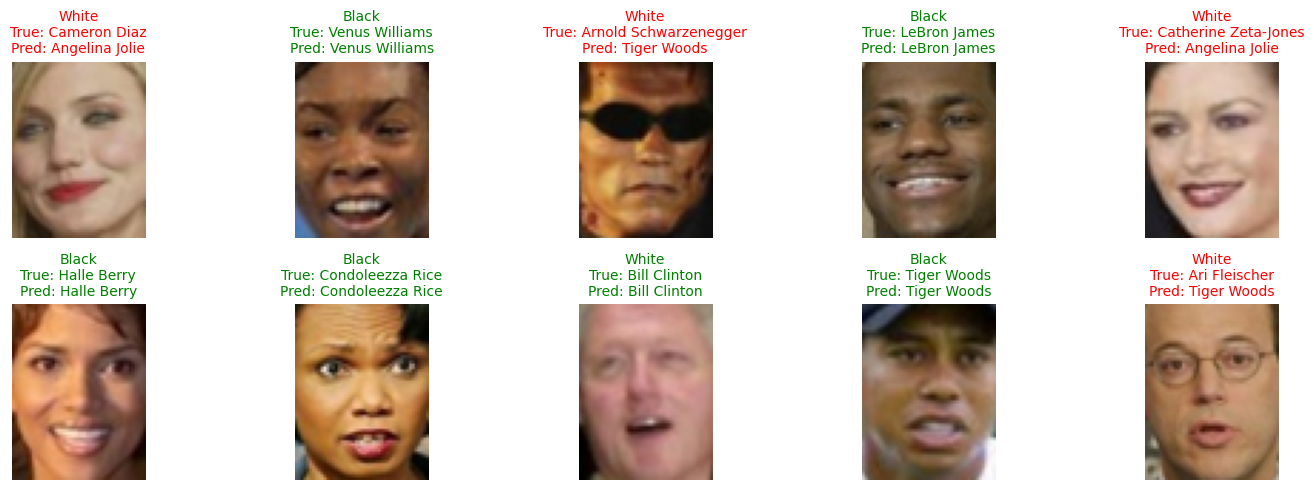

In [136]:
plot_sample_res(X_test, X_embedded, selected_indices, le, y_test, y_pred_cloaked, race_mapping, images)

In [142]:
gender_mapping = {
    "Al Sharpton": "Male",
    "Allyson Felix": "Female",
    "Angela Bassett": "Female",
    "Ashanti": "Female",
    "Chanda Rubin": "Female",
    "Charles Moose": "Male",
    "Condoleezza Rice": "Female",
    "Denzel Washington": "Male",
    "Halle Berry": "Female",
    "James Blake": "Male",
    "Jesse Jackson": "Male",
    "John Allen Muhammad": "Male",
    "LeBron James": "Male",
    "Muhammad Ali": "Male",
    "Russell Simmons": "Male",
    "Serena Williams": "Female",
    "Thabo Mbeki": "Male",
    "Tiger Woods": "Male",
    "Venus Williams": "Female",
    "Adrien Brody": "Male",
    "Al Gore": "Male",
    "Alan Greenspan": "Male",
    "Albert Costa": "Male",
    "Amelie Mauresmo": "Female",
    "Andy Roddick": "Male",
    "Angela Merkel": "Female",
    "Angelina Jolie": "Female",
    "Anna Kournikova": "Female",
    "Ari Fleischer": "Male",
    "Arnold Schwarzenegger": "Male",
    "Ben Affleck": "Male",
    "Bill Clinton": "Male",
    "Bill Gates": "Male",
    "Britney Spears": "Female",
    "Cameron Diaz": "Female",
    "Catherine Zeta-Jones": "Female",
    "Charlton Heston": "Male",
    "Colin Farrell": "Male"
}


In [143]:
records_before = []
records_after = []

for i in range(len(y_test)):
    try:
        orig_idx = selected_indices[test_idx[i]]  # index into full images array
        name = y_names[test_idx[i]]               # name associated with test image
        race = race_mapping.get(name, "Unknown")
        gender = gender_mapping.get(name, "Unknown")
        img = images[orig_idx]
        true_label = le.inverse_transform([y_test[i]])[0]
        pred_label_before = le.inverse_transform([y_pred[i]])[0]
        pred_label_after = le.inverse_transform([y_pred_cloaked[i]])[0]

        records_before.append({
            'name': name,
            'race': race,
            'gender': gender,
            'image': img,
            'true_label': true_label,
            'pred_label': pred_label_before
        })

        records_after.append({
            'name': name,
            'race': race,
            'gender': gender,
            'image': img,
            'true_label': true_label,
            'pred_label': pred_label_after
        })

    except IndexError as e:
        print(f"[!] Skipped index {i} due to: {e}")
        continue

df_before = pd.DataFrame(records_before)
df_after = pd.DataFrame(records_after)
df_before['correct'] = df_before['true_label'] == df_before['pred_label']
df_after['correct'] = df_after['true_label'] == df_after['pred_label']

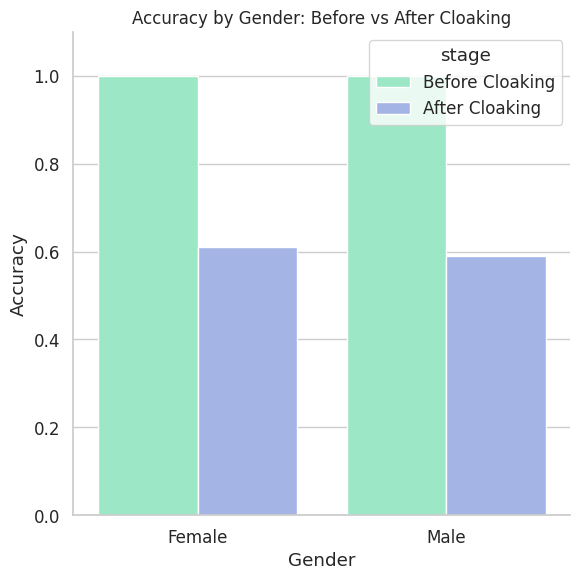

In [146]:
import matplotlib.pyplot as plt

# Compute accuracy per gender
acc_before_gender = df_before.groupby('gender')['correct'].mean().reset_index(name='accuracy')
acc_before_gender['stage'] = 'Before Cloaking'

acc_after_gender = df_after.groupby('gender')['correct'].mean().reset_index(name='accuracy')
acc_after_gender['stage'] = 'After Cloaking'

# Combine
df_acc_gender = pd.concat([acc_before_gender, acc_after_gender], ignore_index=True)

# Plot
plt.figure(figsize=(6, 6))
ax = sns.barplot(data=df_acc_gender, x='gender', y='accuracy', hue='stage', palette=custom_palette)

# Beautify
ax.set_title('Accuracy by Gender: Before vs After Cloaking', fontsize=12)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Gender')
plt.ylim(0, 1.1)
sns.despine()
plt.tight_layout()
plt.show()


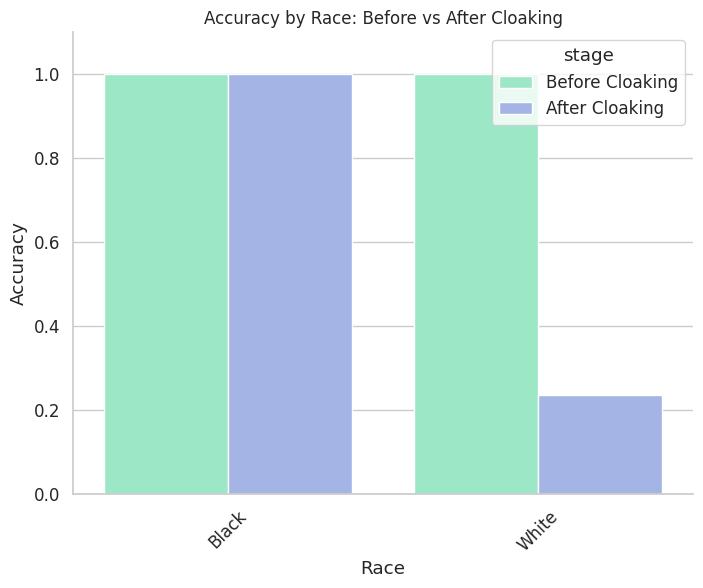

In [145]:
import seaborn as sns


# Compute accuracy per race
acc_before = df_before.groupby('race')['correct'].mean().reset_index(name='accuracy')
acc_before['stage'] = 'Before Cloaking'

acc_after = df_after.groupby('race')['correct'].mean().reset_index(name='accuracy')
acc_after['stage'] = 'After Cloaking'

# Combine into one DataFrame
df_acc = pd.concat([acc_before, acc_after], ignore_index=True)

# Set up the plot
sns.set(style='whitegrid', font_scale=1.1)


custom_palette = {
    "Before Cloaking": "#8EF4C8",  # steel blue
    "After Cloaking": "#99AEF0"   # light sky blue
}


plt.figure(figsize=(8, 6))
ax = sns.barplot(data=df_acc, x='race', y='accuracy', hue='stage', palette=custom_palette)

# Beautify
ax.set_title('Accuracy by Race: Before vs After Cloaking', fontsize=12)
ax.set_ylabel('Accuracy')
ax.set_xlabel('Race')
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
sns.despine()